In [19]:
def convert_path(path):
    """
    Convert a file path with backslashes to forward slashes.
    """
    return path.replace('\\', '/')

# Example usage
original_path = input("Enter the folder path with backslashes: ")

directory = convert_path(original_path)

print("Converted Path:", directory)

# G:/PIV_compare/Bubble_Seep

Converted Path: G:/PIV_compare/Bubble_in_chain


In [20]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator



In [24]:

"""
 u = velocity in z direction U_z
 v = velocity in x direction U_r
"""

# Global variable for the main path
# MAIN_PATH = 'G:/PIV_compare/Bubble_Seep/01082024_Pylon_RaspPi_Cam'


def read_filenames(folder_name, MAIN_PATH):
    """
    Reads all filenames in the specified folder.
a
    :param folder_name: Name of the folder within the main path.
    :return: List of file names.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)
    filenames = []

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return filenames

    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            filenames.append(file)

    return filenames

def check_folder(folder_name, MAIN_PATH):
    """
    Creates a 'figures' folder in the main directory if it doesn't exist.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: '{folder_name}' at {folder_path}")
    else:
        print(f"Folder '{folder_name}' already exists at: {folder_path}")


def process_velocity(data, file_name, correlation_threshold=0.7):
    """
    Processes velocity data and generates plots.

    :param data: Dataset containing 'vel' and 'yphy' variables.
    :param file_name: Name for the output plot files.
    :param correlation_threshold: Threshold for filtering data (default 0.7).
    :return: Tuple of mean velocity arrays (U_mean, V_mean).
    """

    # Read data
    velocity = data['vel'][0]
    print("velocity shape:", velocity.shape)
    y_phy = data['yphy']

    u_components, v_components = [], []
    max_shape = (0, 0)  # Initialize to track the maximum shape


    # Data clean

    for vel in velocity:
        u, v, c = vel['u'], vel['v'], vel['c']
        # print("u shape:", u.shape, "v shape:", v.shape)
            # Skip if u or v is empty
        if u.size == 0 or v.size == 0:
            continue
        mask = c < correlation_threshold
        u[mask] = np.nan
        v[mask] = np.nan

        # Update max_shape if necessary
        max_shape = max(max_shape, u.shape)

        u_components.append(u)
        v_components.append(v)


     # Pad arrays to have the same shape
    u_components_padded = [np.pad(u, ((0, max_shape[0] - u.shape[0]), (0, max_shape[1] - u.shape[1])), 
                                mode='constant', constant_values=np.nan) for u in u_components]
    v_components_padded = [np.pad(v, ((0, max_shape[0] - v.shape[0]), (0, max_shape[1] - v.shape[1])), 
                                mode='constant', constant_values=np.nan) for v in v_components]
    

    u_stack = np.dstack(u_components_padded) if u_components else np.array([])
    v_stack = np.dstack(v_components_padded) if v_components else np.array([])
    
    if u_stack.size > 0 and v_stack.size > 0:
        u_mean, v_mean = np.nanmean(u_stack, axis=2), np.nanmean(v_stack, axis=2)
        #save_velocity_plots(u_mean, v_mean, y_phy, file_name)
        return np.nanmean(u_mean, axis=0), np.nanmean(v_mean, axis=0)
    else:
        print("No valid data to process.")
        return np.array([]), np.array([])

def save_velocity_plots(u_mean, v_mean, y_phy, file_name):
    """
    Saves plots of velocity data.

    :param u_mean: Mean U component of velocity.
    :param v_mean: Mean V component of velocity.
    :param y_phy: Physical Y coordinate array.
    :param file_name: Base name for the output files.
    """
    plt.figure()
    plt.title(f"Mean U Velocity - {file_name}")
    plt.imshow(-u_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/U_{file_name}.png")
    plt.close()

    plt.figure()
    plt.title(f"Mean V Velocity - {file_name}")
    plt.imshow(-v_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/V_{file_name}.png")
    plt.close()

def plot_aggregate_velocity(u_means, v_means, y_physical, MAIN_PATH):
    """
    Plots aggregate velocity data.

    :param u_means: Array of mean U components.
    :param v_means: Array of mean V components.
    :param y_physical: Physical Y coordinate array.
    """
    check_folder('figures', MAIN_PATH)
    
    if u_means.size > 0 and v_means.size > 0:

        max_index = np.argmax(-v_means)
        y_phy_max = y_physical[max_index]
        y = y_physical - y_phy_max
        fig, ax1 = plt.subplots()
        # Plot Mean U Velocity
        color_u = 'tab:red'
        ax1.set_xlabel('$r $(m)')
        ax1.set_ylabel('$U_r \ (m/s)$')
        line1, = ax1.plot(y, -v_means, color=color_u, label='$U_r$')
        ax1.tick_params(axis='y')
        ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce number of x-axis ticks
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Reduce number of y-axis ticks

        # Create a second y-axis for Mean V Velocity
        ax2 = ax1.twinx()  
        color_v = 'tab:blue'
        ax2.set_ylabel('$U_z \ (m/s)$') 
        line2, = ax2.plot(y, -u_means, color=color_v, label='$U_z$')
        ax2.tick_params(axis='y')
        ax2.set_ylim(-0.04, 0.04)
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Reduce number of y-axis ticks for ax2


        # Title and legend
        # plt.title("Aggregate Mean U and V Velocities")
        # Combined legend
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, bbox_to_anchor=(0.98, 1))


        # Save the figure
        plt.savefig(MAIN_PATH+'figures/UV.png')
        plt.show()

        plt.close()
    else:
        print("No valid data to plot.")



velocity shape: (1191,)
file is  velocity_field_removing_bubble_2023-12-01 11-32.mat
velocity shape: (1192,)
file is  velocity_field_removing_bubble_2023-12-01 11-39.mat
velocity shape: (1192,)
file is  velocity_field_removing_bubble_2023-12-01 11-42.mat
velocity shape: (1192,)
file is  velocity_field_removing_bubble_2023-12-01 11-45.mat
u_means_col length: 51
v_means_col length: 51
y_phy length: 51
Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/12012023_Pylon_RaspPi_Cam/figures


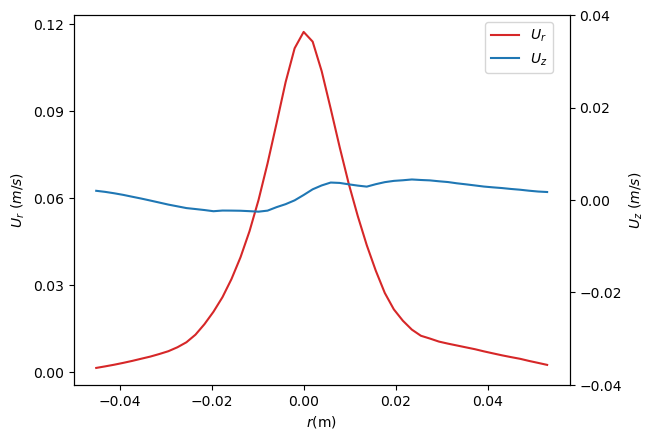

In [25]:

MAIN_PATH_Rasp = directory + '/12012023_Pylon_RaspPi_Cam/' # dont forget the '/'

folder_path = MAIN_PATH_Rasp + 'data'
file_list = read_filenames(folder_path, MAIN_PATH_Rasp)


u_means = []
v_means = []

for file_name in file_list:
    data = sio.loadmat(os.path.join(folder_path, file_name))
    u_mean, v_mean = process_velocity(data, file_name, correlation_threshold=0.7)
    print("file is ",file_name)
    if u_mean.size > 0 and v_mean.size > 0:
        u_means.append(u_mean)
        v_means.append(v_mean)


# Convert lists to NumPy arrays
u_means = np.array(u_means)
v_means = np.array(v_means)

#print("u_means shape:", u_means.shape)
#print("v_means shape:", v_means.shape)

u_means_col = np.mean(u_means, axis=0)
v_means_col = np.mean(v_means, axis=0)
y_phy = data['yphy'].flatten()
print("u_means_col length:", len(u_means_col))
print("v_means_col length:", len(v_means_col))
print("y_phy length:", len(y_phy))

#print("u_means_col shape:", u_means_col.shape)
#print("v_means_col shape:", v_means_col.shape)
#print("y_phy shape:", y_phy.shape)

plot_aggregate_velocity(u_means_col, v_means_col, y_phy, MAIN_PATH=MAIN_PATH_Rasp)




velocity shape: (487,)
file is  velocity_field_removing_bubble_BubbleTest1.mat
velocity shape: (487,)
file is  velocity_field_removing_bubble_BubbleTest2.mat
Length of Y_phy: 79
Y_phy content: [0.00196072 0.00392145 0.00588217 0.0078429  0.00980362 0.01176434
 0.01372507 0.01568579 0.01764652 0.01960724 0.02156796 0.02352869
 0.02548941 0.02745014 0.02941086 0.03137158 0.03333231 0.03529303
 0.03725376 0.03921448 0.0411752  0.04313593 0.04509665 0.04705738
 0.0490181  0.05097882 0.05293955 0.05490027 0.056861   0.05882172
 0.06078244 0.06274317 0.06470389 0.06666462 0.06862534 0.07058606
 0.07254679 0.07450751 0.07646824 0.07842896 0.08038968 0.08235041
 0.08431113 0.08627186 0.08823258 0.0901933  0.09215403 0.09411475
 0.09607548 0.0980362  0.09999692 0.10195765 0.10391837 0.1058791
 0.10783982 0.10980054 0.11176127 0.11372199 0.11568272 0.11764344
 0.11960416 0.12156489 0.12352561 0.12548634 0.12744706 0.12940778
 0.13136851 0.13332923 0.13528996 0.13725068 0.1392114  0.14117213
 0.1

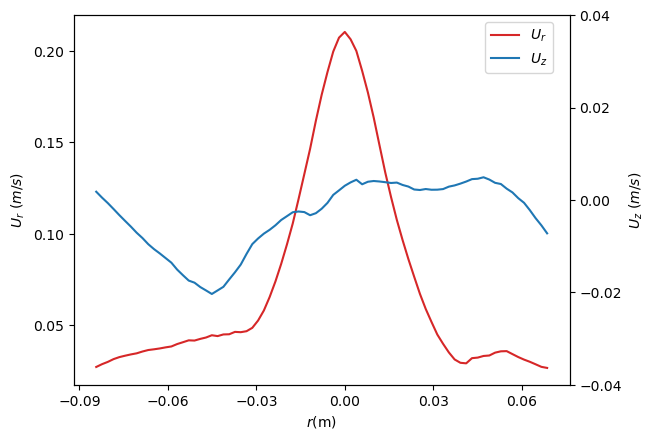

In [26]:
MAIN_PATH_HighSpeed = directory + '/12012023_Phantom_High_Speed_Cam/'

folder_path = MAIN_PATH_HighSpeed + 'data'

file_list = read_filenames(folder_path, MAIN_PATH_HighSpeed)


U_means = []
V_means = []

for file_name in file_list:
    data = sio.loadmat(os.path.join(folder_path, file_name))
    U_mean, V_mean = process_velocity(data, file_name)
    print("file is ",file_name)
    if U_mean.size > 0 and V_mean.size > 0:
        U_means.append(U_mean)
        V_means.append(V_mean)


# Convert lists to NumPy arrays
U_means = np.array(U_means)
V_means = np.array(V_means)
#print("u_means shape:", u_means.shape)
#print("v_means shape:", v_means.shape)

U_means_col = np.mean(U_means, axis=0)
V_means_col = np.mean(V_means, axis=0)
Y_phy = data['yphy'].flatten()
print("Length of Y_phy:", len(Y_phy))
print("Y_phy content:", Y_phy)
plot_aggregate_velocity(U_means_col, V_means_col, Y_phy, MAIN_PATH=MAIN_PATH_HighSpeed)



Folder 'figures' already exists at: G:/PIV_compare/Bubble_in_chain/figures


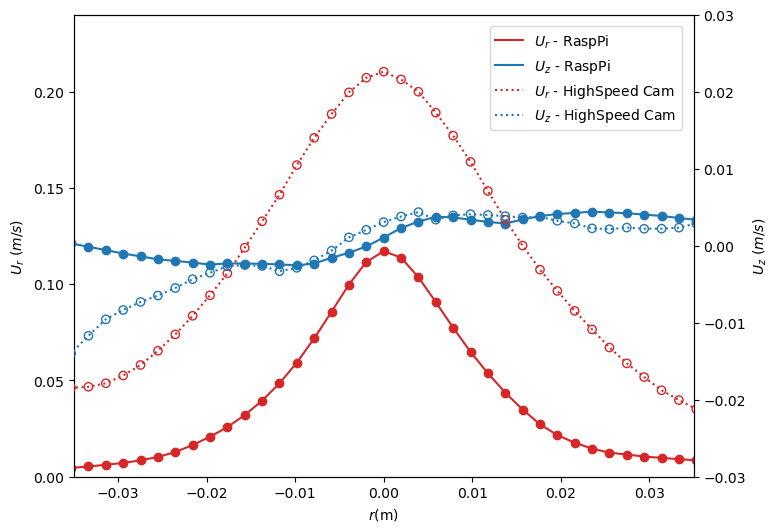

In [27]:

def plot_compare_velocity(u_means, v_means, y_phy, u_means2, v_means2, y_phy2, MAIN_PATH):
    check_folder('figures', MAIN_PATH)

    range_xlim = [-0.035, 0.035]
    range_ylimL = [0, 0.24]
    range_ylimR = [-0.03, 0.03]
    range_xlimT = [-0.035, 0.035]
    if u_means.size > 0 and v_means.size > 0:
        max_index = np.argmax(-v_means)
        y_phy_max = y_phy[max_index]
        y = y_phy - y_phy_max

        max_index2 = np.argmax(-v_means2)
        y_phy_max2 = y_phy2[max_index2]
        y2 = y_phy2 - y_phy_max2

        fig, ax1 = plt.subplots(figsize=(8, 6))
        
        # Plot Mean U Velocity
        color_v = 'tab:red'
        ax1.set_xlabel('$r $(m)')
        ax1.set_ylabel('$U_r \ (m/s)$')
        line1, = ax1.plot(y, -v_means, color=color_v, label='$U_r$ - RaspPi')
        ax1.scatter(y, -v_means, color=color_v)
        ax1.tick_params(axis='y')
        ax1.set_xlim(range_xlim[0], range_xlim[1])
        ax1.set_ylim(range_ylimL[0], range_ylimL[1])
        # Create a second y-axis for Mean V Velocity
        ax2 = ax1.twinx()  
        color_u = 'tab:blue' 
        ax2.set_ylabel('$U_z \ (m/s)$') 
        line2, = ax2.plot(y, -u_means, color=color_u, label='$U_z$ - RaspPi')
        ax2.scatter(y, -u_means, color=color_u)
        ax2.tick_params(axis='y')
        ax2.set_ylim(range_ylimR[0], range_ylimR[1])
        ax2.set_xlim(range_xlimT[0], range_xlimT[1])
        # Create a second x-axis for u_means2 and v_means2
        ax3 = plt.axes(ax1.get_position(), frameon=False)
        

        line3, = ax3.plot(y2, -v_means2, color=color_v,linestyle=':', label='$U_r$ - HighSpeed Cam')
        ax3.scatter(y2, -v_means2, color=color_v, facecolors='none')

        ax3.set_xlim(range_xlim[0], range_xlim[1])
        ax3.set_ylim(range_ylimL[0], range_ylimL[1])

        ax4 = plt.axes(ax2.get_position(), frameon=False)
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax4.yaxis.set_major_locator(MaxNLocator(nbins=6))
        line4, = ax4.plot(y2, -u_means2, color=color_u,linestyle=':', label='$U_z$ - HighSpeed Cam')
        ax4.scatter(y2, -u_means2, color=color_u, facecolors='none')

        ax4.set_ylim(range_ylimR[0], range_ylimR[1])
        ax4.set_xlim(range_xlimT[0], range_xlimT[1])


        # Make ax3 ax4 invisible
        for spine in ax3.spines.values():
            spine.set_visible(False)
        ax3.xaxis.set_visible(False)
        ax3.yaxis.set_visible(False)
        for spine in ax4.spines.values():
            spine.set_visible(False)
        ax4.xaxis.set_visible(False)
        ax4.yaxis.set_visible(False)

        # Combined legend
        lines = [line1, line2, line3, line4]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, bbox_to_anchor=(0.66, 0.99), loc='upper left')

        # Save and show the figure
        plt.savefig(MAIN_PATH + 'figures/UV_comparison.png', bbox_inches='tight')
        plt.show()
        plt.close()
    else:
        print("No valid data to plot.")

plot_compare_velocity(u_means_col, v_means_col, y_phy, U_means_col, V_means_col, Y_phy, MAIN_PATH=directory+'/')
